# Advanced plotting with pySW4

In [2]:
import os
import sys

import pySW4 as sw4
import obspy
import matplotlib.pyplot as plt
import numpy as np

## Comparison of matplotlib blending modes

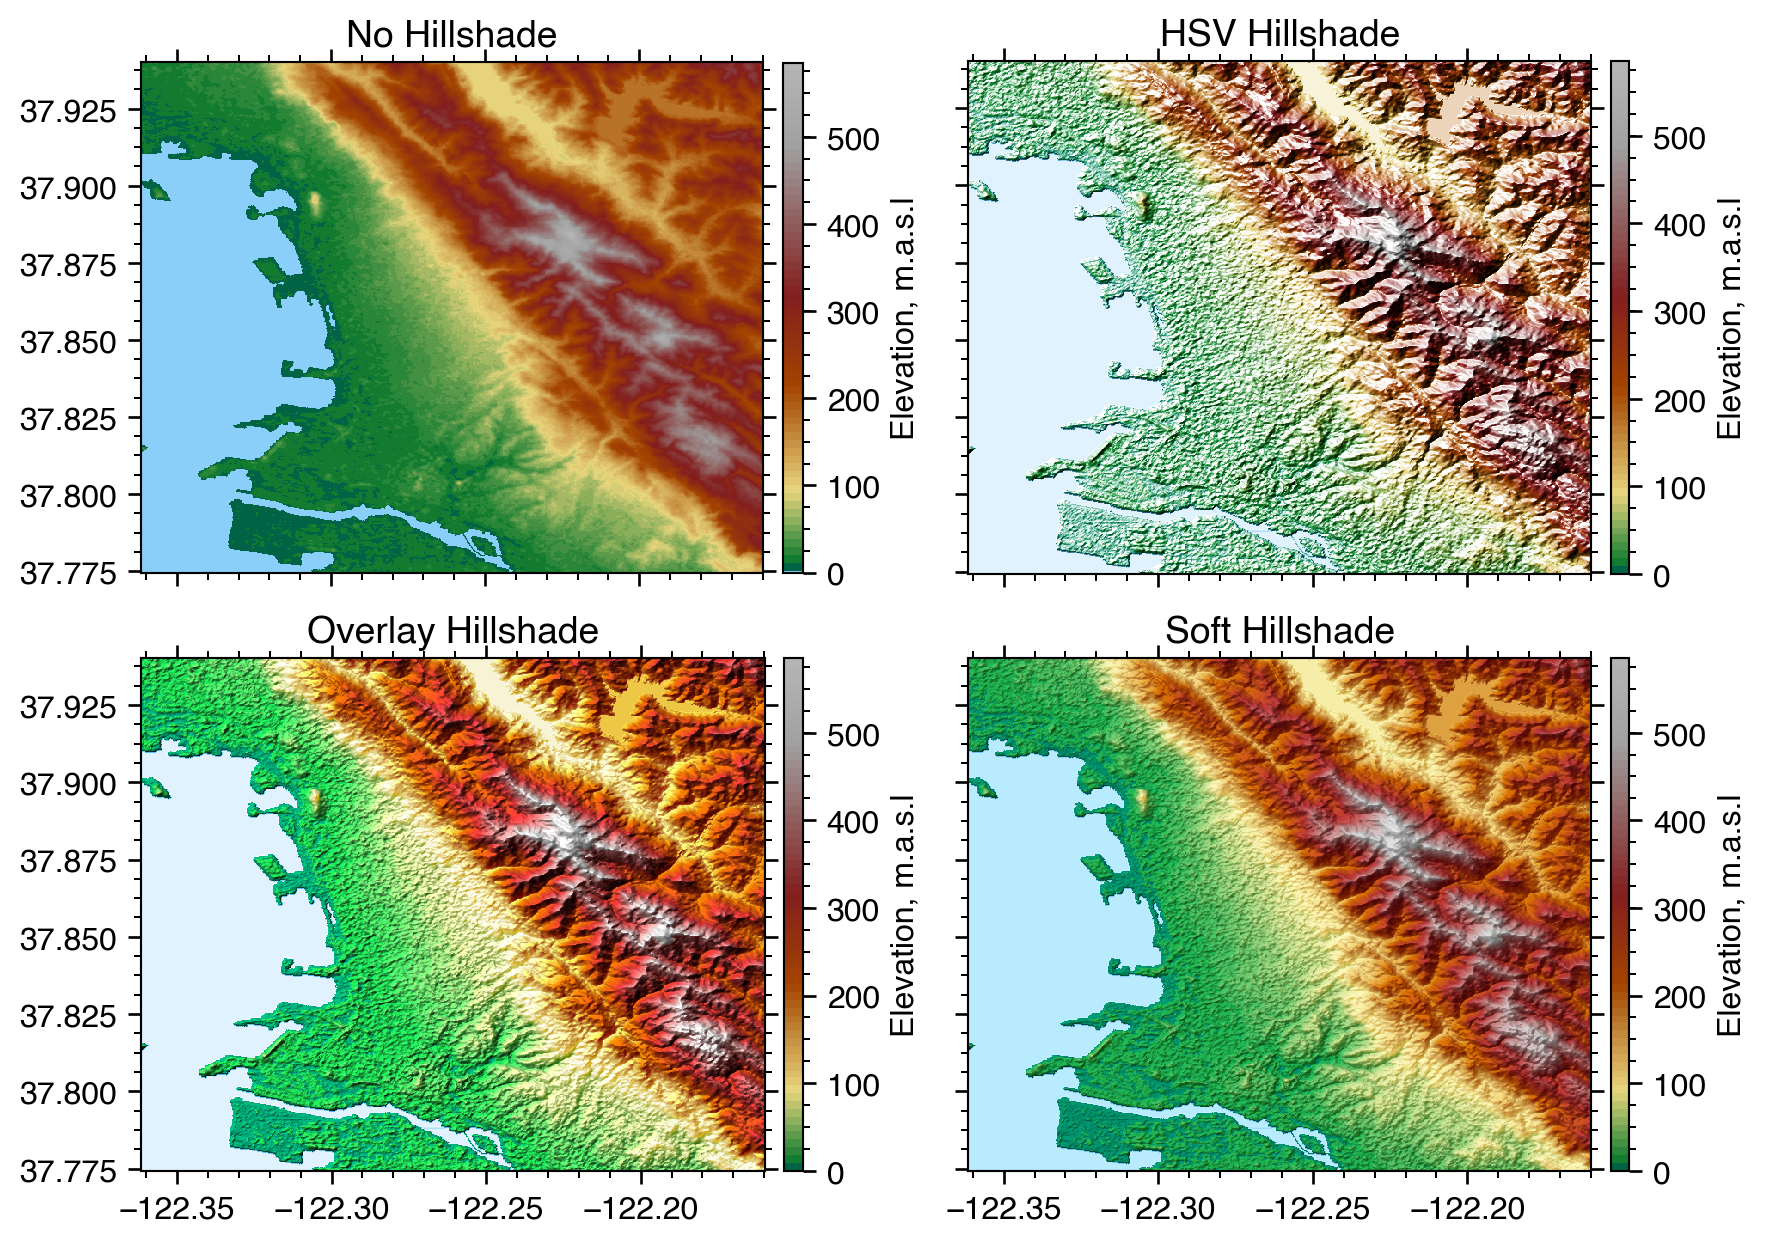

In [3]:
from pycpt.load import cmap_from_cptcity_url

aster = '/Users/shahar/data/AsterGDEM/'

w, e, s, n = -122.35126, -122.17006, 37.784317, 37.93
w, e, s, n = w - 0.01, e + 0.01, s - 0.01, n + 0.01
topo = sw4.utils.geo.get_dem(aster, w, e, s, n)

# hillshade parameters
definition = 0.5
contrast = 1.1

# cmap and labels
cmap = cmap_from_cptcity_url(u'mby/mby.cpt')

# stretch the cmap to the desired colors
cmax = topo.elev.max() * 1.5
cmin = -cmax * 1.58
norm = plt.Normalize(cmin, cmax)

# set the plotting vmin and vmax
vmax = topo.elev.max()
vmin = 0
cmap = sw4.utils.trim_cmap(cmap, norm(vmin), norm(vmax))

cb_label = 'Elevation, m.a.s.l'

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(wspace=0.25, hspace=-0.3)
ax = ax.ravel()

# No hillshading
im = ax[0].imshow(topo.elev, extent=topo.extent, cmap=cmap,
                  vmin=vmin, vmax=vmax)
ax[0].set_title('No Hillshade')
plt.colorbar(im, ax=ax[0], fraction=0.03, pad=0.03, aspect=25.7, label=cb_label)
ax[0].set_xticklabels([])

# HSV Hillshading
sw4.plotting.hillshade_plot(
    topo.elev, extent=topo.extent, cmap=cmap, vmin=vmin, vmax=vmax,
    blend_mode='hsv', contrast=contrast, definition=definition, ax=ax[1],
    colorbar=cb_label)
ax[1].set_title('HSV Hillshade')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])

# Overlay Hillshading
sw4.plotting.hillshade_plot(
    topo.elev, extent=topo.extent, cmap=cmap, vmin=vmin, vmax=vmax,
    blend_mode='overlay', contrast=contrast, definition=definition, ax=ax[2],
    colorbar=cb_label)

ax[2].set_title('Overlay Hillshade')

# Soft Hillshading
sw4.plotting.hillshade_plot(
    topo.elev, extent=topo.extent, cmap=cmap, vmin=vmin, vmax=vmax,
    blend_mode='soft', contrast=contrast, definition=definition, ax=ax[3],
    colorbar=cb_label)

ax[3].set_title('Soft Hillshade')
ax[3].set_yticklabels([])
fig.savefig('hillshade.png', dpi=300)

## Draping an SW4 image on a shaded relief

/Users/shahar/anaconda2/lib/python2.7/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


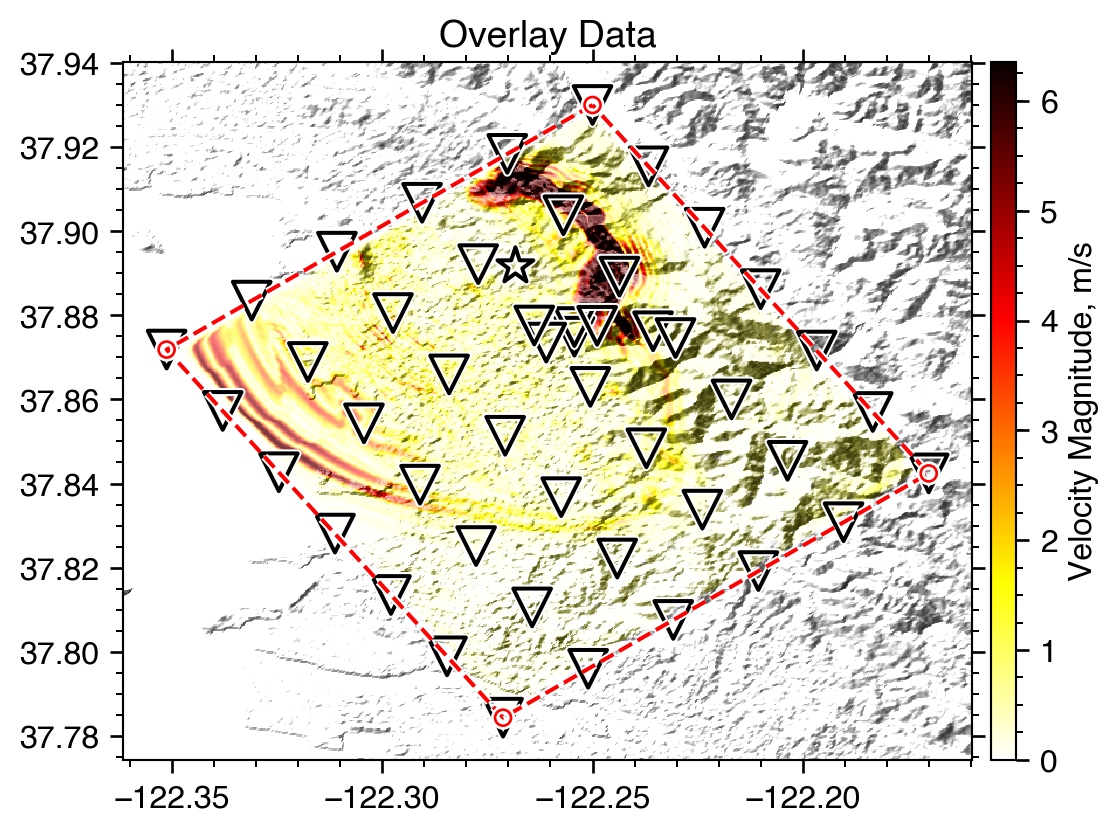

In [4]:
from matplotlib import patheffects

# read DEM
topo = sw4.utils.geo.get_dem(aster, w, e, s, n)

# read the sw4 input and stdout file
input_, output_ = sw4.read_metadata('../sw4-v1.1/examples/rfile/berkeley.sw4',
                                    '../sw4-v1.1/examples/rfile/mon.txt')



# read SW4 image
f = '../sw4-v1.1/examples/rfile/results/berkeley.cycle=01402.z=0.magdudt.sw4img'
lons_ = '../sw4-v1.1/examples/rfile/results/berkeley.cycle=00000.z=0.lon.sw4img'
lats_ = '../sw4-v1.1/examples/rfile/results/berkeley.cycle=00000.z=0.lat.sw4img'
image = sw4.read_image(f, input_)
lons = sw4.read_image(lons_)
lats = sw4.read_image(lats_)

# projection parmaeters
proj = input_.proj4
lon0 = input_.grid[0].lon
lat0 = input_.grid[0].lat
az = input_.grid[0].az

# get the computation domain limits
corners = sw4.utils.get_corners(lons.patches[0].data, lats.patches[0].data)
domain = sw4.utils.close_polygon(*corners)

# hillshade parameters
definition = 0.5
contrast = 0.8

# cmap, label, and path effects
cmap = plt.get_cmap('hot_r')
cmap.set_under('w')
cb_label = '{}, {}'.format(image.quantity_name, image.quantity_unit)

pe = [patheffects.withStroke(linewidth=3, foreground="w")]

fig, ax = plt.subplots(figsize=(6, 6))

XYZ = (lons.patches[0].data,
       lats.patches[0].data,
       image.patches[0].data)
data = sw4.utils.resample(XYZ, topo.extent, topo.elev.shape)[-1]

# Overlay data drape
sw4.plotting.drape_plot(
    data[::-1], topo.elev, extent=topo.extent, cmap=cmap, vmax='3',
    blend_mode='hsv', contrast=contrast, definition=definition, ax=ax,
    colorbar=cb_label)

# Scatter stations and source
lon, lat = sw4.utils.geographic2cartesian(
    proj, lon0=lon0, lat0=lat0, az=az,
    x=input_.source[0].x, y=input_.source[0].y)
ax.scatter(lon, lat, 200, marker='*', edgecolors='k', facecolors='none', lw=1.5,
           path_effects=pe)

sta_coordinates = []
for sta in input_.rec:
    try:  # get the x, y coordinates and project tem to lon, lat
        lon, lat = sw4.utils.geographic2cartesian(
            proj, lon0=lon0, lat0=lat0, az=az,
            x=sta.x, y=sta.y)
    except AttributeError:  # station coordinates already in lon, lat
        lon, lat = sta.lon, sta.lat
    sta_coordinates += [[lon, lat]]
lon, lat = np.array(sta_coordinates).T
ax.scatter(lon, lat, 200, marker='v', edgecolors='k', facecolors='none', lw=1.5,
           path_effects=pe)

# Plot the computational domain extent
ax.scatter(*corners, c='none', edgecolor='r', zorder=3, path_effects=pe)
ax.plot(*domain, color='r', ls='dashed', path_effects=pe)

ax.axis(topo.extent)
ax.set_aspect(1)
ax.set_title('Overlay Data')

## Making your own cmap

In [5]:
colors = ('white','plum','orchid','indigo','green','yellow','orange','red', 'darkred')
positions = (0,    0.1,     0.15,   0.2,  0.25,   0.4,     0.5,    0.9,   1)
cmap = sw4.utils.make_cmap(colors, positions)

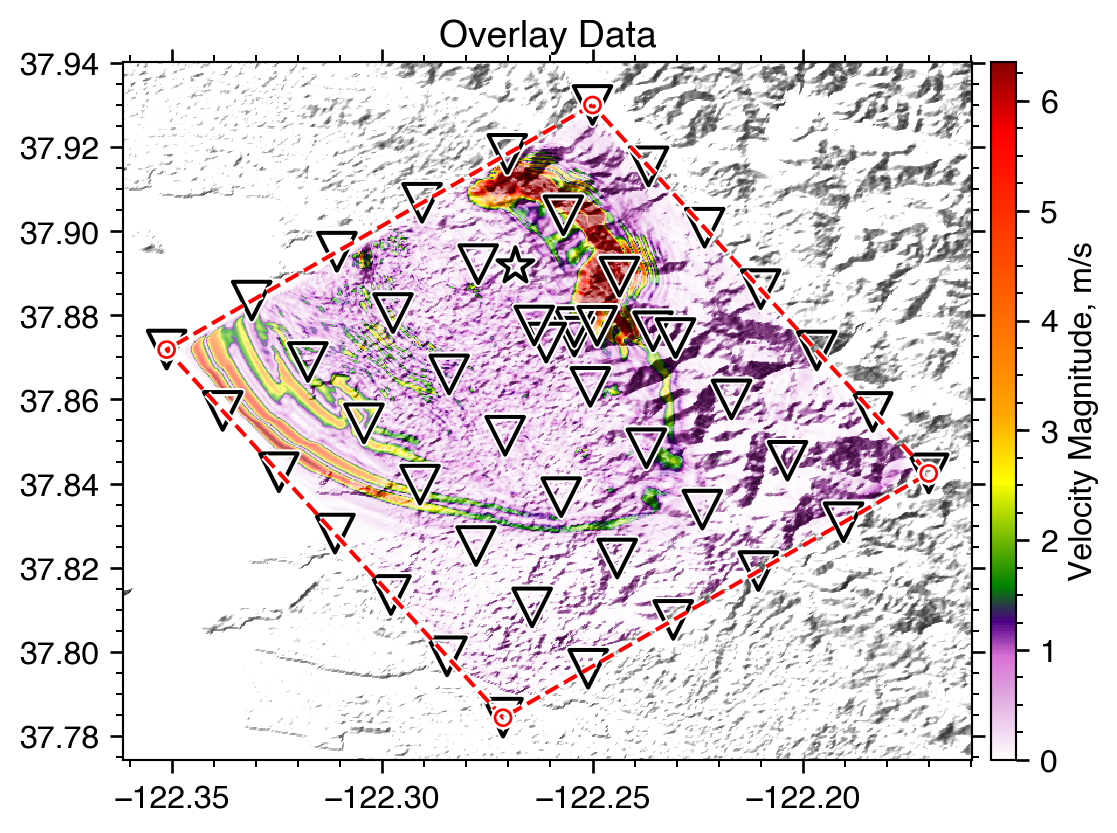

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))

XYZ = (lons.patches[0].data,
       lats.patches[0].data,
       image.patches[0].data)
data = sw4.utils.resample(XYZ, topo.extent, topo.elev.shape)[-1]

# Overlay data drape
sw4.plotting.drape_plot(
    data[::-1], topo.elev, extent=topo.extent, cmap=cmap, vmax='3',
    blend_mode='hsv', contrast=contrast, definition=definition, ax=ax,
    colorbar=cb_label)

# Scatter stations and source
lon, lat = sw4.utils.geographic2cartesian(
    proj, lon0=lon0, lat0=lat0, az=az,
    x=input_.source[0].x, y=input_.source[0].y)
ax.scatter(lon, lat, 200, marker='*', edgecolors='k', facecolors='none', lw=1.5,
           path_effects=pe)

sta_coordinates = []
for sta in input_.rec:
    try:  # get the x, y coordinates and project tem to lon, lat
        lon, lat = sw4.utils.geographic2cartesian(
            proj, lon0=lon0, lat0=lat0, az=az,
            x=sta.x, y=sta.y)
    except AttributeError:  # station coordinates already in lon, lat
        lon, lat = sta.lon, sta.lat
    sta_coordinates += [[lon, lat]]
lon, lat = np.array(sta_coordinates).T
ax.scatter(lon, lat, 200, marker='v', edgecolors='k', facecolors='none', lw=1.5,
           path_effects=pe)

# Plot the computational domain extent
ax.scatter(*corners, c='none', edgecolor='r', zorder=3, path_effects=pe)
ax.plot(*domain, color='r', ls='dashed', path_effects=pe)

ax.axis(topo.extent)
ax.set_aspect(1)
ax.set_title('Overlay Data')